## Iterative solution of an elliptic eqn

* Take the following equation
$$
-\nabla^2 \phi = q \;\; q = 2(2-x^2 - y^2)
$$
* with boundary conditions
$$
\phi(\pm 1, y) = 0, \;\; \phi(x, \pm 1)=0
$$
* We will choose as an initial guess for our iterative solution $\phi^{(0)}(x, y) = 0$. The problem will be solved with the point Jacobi, Gauss–Seidel, and SOR algorithms.

* Spatial derivatives are calculated with second-order central differences, as used in the course $(\Delta x =\Delta y = \Delta)$.
$$
\dfrac{\phi_{i+1,j} -2\phi_{i,j} + \phi_{i-1,j}}{\Delta^2} + \dfrac{\phi_{i,j+1} -2\phi_{i,j} + \phi_{i,j-1}}{\Delta^2} = q_{i,j}
$$

#### Libraries

In [1]:
import numpy as np
import scipy.sparse as sp
import math
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d

import os, sys
sys.path.append('src')
from utility import *

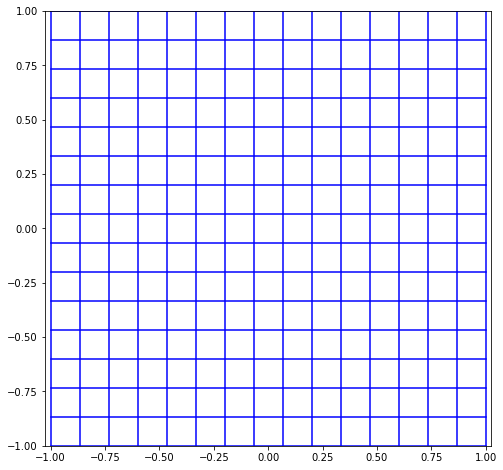

array([-1.        , -0.86666667, -0.73333333, -0.6       , -0.46666667,
       -0.33333333, -0.2       , -0.06666667,  0.06666667,  0.2       ,
        0.33333333,  0.46666667,  0.6       ,  0.73333333,  0.86666667,
        1.        ])

In [2]:
# Mesh

m    = 16
n    = 16
x    = np.linspace(-1, 1, num = m) #[1:-1] 
y    = np.linspace(-1, 1, num = n) #[1:-1]

dytmp, dxtmp = np.diff(y), np.diff(x)
delta= 2/(m-1)

# -----------------------------------

plt.figure(figsize=(8,8))

X, Y = np.meshgrid(x, y)

plt.plot(X, Y, 'b-')
plt.plot(X.T, Y.T, 'b-')

plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.show()

x

In [3]:
# point Jacobi 

def Jacobi(phi0, q, n, m, delta):
    
    """ Jacobian method """
        
    # Initial    
    #u = np.zeros((n, m))
    phi = phi0.copy()

    for i in range(1,n-1):
        for j in range(1,m-1):
            phi[i,j] = .25*(phi0[i-1,j] + phi0[i+1,j] + phi0[i,j-1] + phi0[i,j+1]) + ((delta**2)/4)*q[i,j]
            
    return phi
    
# GS 

def GS(phi0, q, n, m, delta):
     
    """ GS method """
       
    # Initial    
    #u = np.zeros((n, m))
    phi = phi0.copy()
    
    for i in range(1,n-1):
        for j in range(1,m-1):
            phi[i,j] = .25*(phi[i-1,j] + phi0[i+1,j] + phi[i,j-1] + phi0[i,j+1]) + ((delta**2)/4)*q[i,j]
        
    return phi

# SOR

def SOR(phi0, q, n, m, delta, omega):

    """ SOR method """

    phi    = phi0.copy()
    phi_SOR = phi0.copy()
    
    for i in range(1,n-1):
        for j in range(1,m-1):
            phi_SOR[i,j] = .25*(phi[i-1,j] + phi[i+1,j] + phi[i,j-1] + phi[i,j+1]) + ((delta**2)/4)*q[i,j]
            phi[i,j]    = phi[i,j] + omega*(phi_SOR[i,j] - phi[i,j])
    
    return phi


### Exact solution

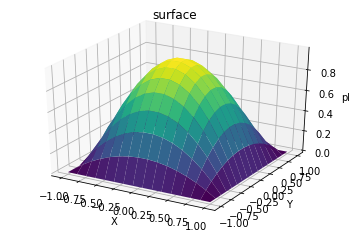

In [4]:
phi_exact = (X**2 - 1)*(Y**2 - 1)

ax  = plt.axes(projection='3d')
ax.plot_surface(X, Y, phi_exact, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax.set_title('surface');
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('phi')

plt.show()

### Initial condition

In [5]:
s     = (n,m)
phi_0 = np.zeros(s)

### Evaluate right-hand-side

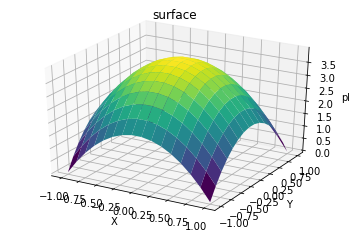

In [6]:
q = 2*(2 - X**2 - Y**2)

ax  = plt.axes(projection='3d')
ax.plot_surface(X, Y, q, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax.set_title('surface');
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('phi')

plt.show()

In [7]:
phi          = phi_0
error        = np.sum(np.abs(phi - phi_exact))/np.sum(phi_exact)
counter      = 0  

kmax         = 5*10**3

while error > 10**-6:
    #phi_temp    = Jacobi(phi, q, n, m, delta)
    #phi_temp    = GS(phi, q, n, m, delta)
    phi_temp    = SOR(phi, q, n, m, delta, 1.7)
    error       = np.sum(np.abs(phi_temp - phi_exact))/np.sum(phi_exact)
    counter    += 1
    phi         = phi_temp
    
    if counter == kmax:
        print('Max iterations reached')
        break

error

8.694117495574663e-07

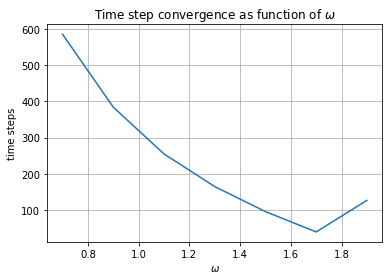

In [8]:
OMEGA = np.array([0.7+i*0.2 for i in range (7)])

counterT = 0

for omega in OMEGA :
    phi          = phi_0
    error        = np.sum(np.abs(phi - phi_exact))/np.sum(phi_exact)
    counter      = 0 
    
    while error > 10**-6:
        #phi_temp   = Jacobi(phi, q, n, m, delta)
        #phi_temp   = GS(phi, q, n, m, delta)
        phi_temp   = SOR(phi, q, n, m, delta, omega)
        
        error      = np.sum(np.abs(phi_temp - phi_exact))/np.sum(phi_exact)

        counter    += 1
        phi        = phi_temp
    
    counterT = np.append(counterT, counter)
counterT = counterT[1:]

# ------------------------------------------

plt.figure()

plt.plot(OMEGA, counterT)

plt.title(r'Time step convergence as function of $\omega$')
plt.xlabel(r'$\omega$')
plt.ylabel('time steps')

plt.grid('True')

In [20]:
print(f'Optimal omega to lower time step is {OMEGA[np.where(counterT==min(counterT))][0]}')

Optimal omega to lower time step is 1.7


Overall, here are the number of iterations needed to reach same $\epsilon = 10^{-6}$ for different mesh size :

In [35]:
import pandas as pd
data = [[625, 313, 40], [2681, 1341, 219], [11084, 5543, 962]]
pd.DataFrame(data, index=["16x16", "32x32", "64x64"], columns=["Jacobi", "Gauss-Seidel", "SOR"])

,Jacobi,Gauss-Seidel,SOR
16x16,625,313,40
32x32,2681,1341,219
64x64,11084,5543,962


$\underline{\text{Note}}$ : 
- **SOR method's results are there obtained using optimal $\omega$ calculated just before.**

- **Gauss-seidel as expected is twice faster than Jacobi (i.e. see eigen values), which the slower method here.**